In [31]:
import json
import os
from os.path import join as path_join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py2neo import Graph
from tqdm import tqdm

In [5]:
gi50_path = os.path.join("data", "GI50.csv")
nsc2synonymId_path = os.path.join("data", "nsc2synom_id.csv")

with open("config.json") as f:
    config = json.load(f)

neo4j_url = config.get("neo4jUrl", "bolt://localhost:7687")
user = config.get("user", "neo4j")
pswd = config.get("pswd", "password")
neo4j_import_loc = config["neo4j_import_loc"]

Using the csv itself as reverence.
It is not perfect because some cell lines of chemicals could not be loaded.

In [6]:
gi50 = pd.read_csv(path_join("data", "GI50.csv"))
print(gi50.shape)
gi50.head()

(4585048, 14)


,RELEASE_DATE,EXPID,PREFIX,NSC,CONCENTRATION_UNIT,LOG_HI_CONCENTRATION,PANEL_NUMBER,CELL_NUMBER,PANEL_NAME,CELL_NAME,PANEL_CODE,COUNT,AVERAGE,STDDEV
0,20210223,0001MD02,S,123127,M,-4.6021,1,1,Non-Small Cell Lung Cancer,NCI-H23,LNS,1,-7.1391,0.0
1,20210223,0001MD02,S,123127,M,-4.6021,10,14,Melanoma,M14,MEL,1,-7.0520,0.0
2,20210223,0001MD02,S,123127,M,-4.6021,12,5,CNS Cancer,SNB-75,CNS,1,-7.1380,0.0
3,20210223,0001MD02,S,123127,M,-4.6021,4,2,Colon Cancer,HCC-2998,COL,1,-6.9426,0.0
4,20210223,0001MD02,S,123127,M,-4.6021,5,5,Breast Cancer,MDA-MB-231/ATCC,BRE,1,-6.4485,0.0


Creating a pivot table. Where every value is the average GI50 value of the combination cell line (row) and chemical (column). This makes the data easier to work with.

In [7]:
correlation = pd.pivot_table(gi50, values='AVERAGE', index=['CELL_NAME'],
                    columns=['NSC'], aggfunc=np.mean)
correlation.head()

NSC,1,17,26,89,112,171,185,186,196,197,...,836824,836941,836942,837081,837082,837396,837397,837398,837892,837893
CELL_NAME,,,,,,,,,,,,,,,,,,,,,
786-0,-4.716867,-5.557233,-5.4265,-4.70005,-6.4911,-4.0,-7.4287,-4.609967,-5.1022,-5.5461,...,-5.4324,-5.3468,-4.0,-4.8286,-5.1042,-6.6969,-5.5047,-6.5669,-4.301,-5.6072
A-172/H.Fine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.230500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A-204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A-C/EBP 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A-CREB 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
selected_cells = correlation[correlation.count(axis=1) > 9000]
print(selected_cells.shape)
selected_cells.head()

(71, 56685)


NSC,1,17,26,89,112,171,185,186,196,197,...,836824,836941,836942,837081,837082,837396,837397,837398,837892,837893
CELL_NAME,,,,,,,,,,,,,,,,,,,,,
786-0,-4.716867,-5.557233,-5.4265,-4.700050,-6.49110,-4.0,-7.42870,-4.609967,-5.1022,-5.5461,...,-5.4324,-5.3468,-4.0000,-4.8286,-5.1042,-6.69690,-5.5047,-6.56690,-4.301,-5.6072
A498,-4.363500,-4.664067,NaN,-4.144533,-6.13750,-4.0,NaN,-5.458580,-4.9329,-4.8278,...,-5.3284,-4.0000,-4.0000,-4.8123,-4.8738,-5.75485,-5.4407,-6.79295,-4.301,-5.6273
A549/ATCC,-4.436033,-4.000000,-5.2279,-4.186133,-6.55095,-4.0,-7.43735,-4.304214,-4.7654,-4.8402,...,-5.4769,-5.2734,-4.0000,-4.7343,-5.3175,-6.73505,-5.2837,-5.70005,-4.301,-5.5114
ACHN,-5.287300,-4.000000,-4.9223,-4.240067,-6.76120,-4.0,-7.53630,-4.677900,-5.3456,-5.6135,...,-5.4376,-4.0375,-4.0000,-4.7424,-5.2010,-7.14220,-5.2331,-6.79450,-4.301,-5.6512
BT-549,-4.814733,-6.516400,NaN,NaN,-6.20805,-4.0,NaN,-4.876133,-4.7954,-4.8428,...,-5.5244,-5.7567,-4.0063,-4.8669,-5.3374,-7.12005,-5.7995,-6.54240,-4.301,-5.6164


In [9]:
selected_GI50 = selected_cells.loc[:, selected_cells.count() > 20]
print(selected_GI50.shape)
selected_GI50.head()

(71, 56658)


NSC,1,17,26,89,112,171,185,186,196,197,...,836824,836941,836942,837081,837082,837396,837397,837398,837892,837893
CELL_NAME,,,,,,,,,,,,,,,,,,,,,
786-0,-4.716867,-5.557233,-5.4265,-4.700050,-6.49110,-4.0,-7.42870,-4.609967,-5.1022,-5.5461,...,-5.4324,-5.3468,-4.0000,-4.8286,-5.1042,-6.69690,-5.5047,-6.56690,-4.301,-5.6072
A498,-4.363500,-4.664067,NaN,-4.144533,-6.13750,-4.0,NaN,-5.458580,-4.9329,-4.8278,...,-5.3284,-4.0000,-4.0000,-4.8123,-4.8738,-5.75485,-5.4407,-6.79295,-4.301,-5.6273
A549/ATCC,-4.436033,-4.000000,-5.2279,-4.186133,-6.55095,-4.0,-7.43735,-4.304214,-4.7654,-4.8402,...,-5.4769,-5.2734,-4.0000,-4.7343,-5.3175,-6.73505,-5.2837,-5.70005,-4.301,-5.5114
ACHN,-5.287300,-4.000000,-4.9223,-4.240067,-6.76120,-4.0,-7.53630,-4.677900,-5.3456,-5.6135,...,-5.4376,-4.0375,-4.0000,-4.7424,-5.2010,-7.14220,-5.2331,-6.79450,-4.301,-5.6512
BT-549,-4.814733,-6.516400,NaN,NaN,-6.20805,-4.0,NaN,-4.876133,-4.7954,-4.8428,...,-5.5244,-5.7567,-4.0063,-4.8669,-5.3374,-7.12005,-5.7995,-6.54240,-4.301,-5.6164


In [10]:
# Matrix density 
selected_GI50.isna().sum().sum()/selected_GI50.size

0.20877476372939888

# Distance between 2 chemicals
The difference in how 2 chemicals react to the same cell lines gives us an idea how similar those 2 chemicals are. If we take the average of these differences a distance between the two chemicals. Where 0 means the chemicals are the same, and infinite means they could not be more different.
Below we use pandas to get the difference between NSC 19893 and NSC 713724.

In [11]:
all_diffs_pd = np.abs(selected_GI50[19893] - selected_GI50[713724])
print(f"Avg diff {all_diffs_pd.mean()}, num cell lines used {sum(all_diffs_pd.notna())}")

Avg diff 0.5365136610125857, num cell lines used 59


In [12]:
all_diffs_np = np.abs(np.expand_dims(correlation[1].to_numpy(), 1) - correlation.to_numpy())
all_diffs_2_1 = []
for nsc, mean in zip(correlation.columns, np.nanmean(all_diffs_np, 0)):
    all_diffs_2_1.append([mean, nsc])

sorted(all_diffs_2_1, key=lambda x: x[0])[:10]

[[0.0, 1],
 [0.13239532163742682, 669504],
 [0.1431254901960784, 66457],
 [0.15246694915254239, 708393],
 [0.1635098870056496, 676441],
 [0.1638216666666666, 704884],
 [0.1641491525423729, 709748],
 [0.16600517241379292, 669516],
 [0.16689039548022586, 685107],
 [0.16693663793103444, 640192]]

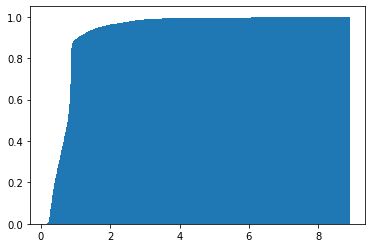

In [13]:
all_values = np.array(all_diffs_2_1)[:, 0]
filters_values = all_values[all_values > 0]
counts, bins = np.histogram(filters_values, bins=1000)

_ = plt.hist(bins[:-1], bins, weights=counts, density=True, cumulative=True)

In [14]:
filters_values.sort()

In [15]:
filters_values[100]

0.19627191358024693

In [16]:
np.sum(filters_values < 0.3)

4580

In [17]:
correlation.columns[all_values == filters_values[100]]

Int64Index([700503], dtype='int64', name='NSC')

# Connect all chemicals

In [54]:
from tqdm import tqdm

max_csv_rows = 1e6
num_csv_files = 1

num_chemicals = correlation.shape[1]
all_distances = []
correlation_np = correlation.to_numpy()
for i in tqdm(range(num_chemicals)):
    all_diffs_np = np.abs(np.expand_dims(correlation_np[:, i], 1) - correlation_np[:, i:])
    all_diffs_np = np.nanmean(all_diffs_np, 0, dtype=np.float16)
    pos_chems = np.where(all_diffs_np <= 0.4)[0]
    all_nsc_names = correlation.columns[pos_chems + i]
    diffs = all_diffs_np[pos_chems]

    nsc_number_of_intrest = correlation.columns[i]
    for diff, nsc_number in zip(diffs, all_nsc_names):
        if nsc_number == nsc_number_of_intrest:
            continue
        all_distances.append([nsc_number_of_intrest, diff, nsc_number])
    
    if len(all_distances) > max_csv_rows:
        pd.DataFrame(all_distances, columns=["nsc_1", "value", "nsc_2"]).to_csv(path_join(neo4j_import_loc, f"results_{num_csv_files}.csv"), index=False)
        all_distances = []
        num_csv_files += 1
pd.DataFrame(all_distances, columns=["nsc_1", "value", "nsc_2"]).to_csv(path_join(neo4j_import_loc, f"results_{num_csv_files}.csv"), index=False)

  0%|          | 15/56685 [00:02<2:43:13,  5.79it/s]C:\Users\tomni\AppData\Local\Temp\ipykernel_15684\1451230001.py:11: RuntimeWarning: Mean of empty slice
  all_diffs_np = np.nanmean(all_diffs_np, 0, dtype=np.float16)
100%|██████████| 56685/56685 [1:44:05<00:00,  9.08it/s]  


In [19]:
graph = Graph(neo4j_url, auth=(user, pswd))

response = graph.run(
    """
    UNWIND $all_nsc_numbers as nsc_number
    CREATE (c:Chemical {nscNumber: toInteger(nsc_number)})
""",
    all_nsc_numbers=correlation.columns.to_list(),
)

In [20]:
response = graph.run(
    """
    CREATE constraint synonymId if not exists for (c:Chemical) require c.nscNumber is unique;
    """
)

In [28]:
for i in tqdm(range(1, num_csv_files+1)):
    response = graph.run(
        """
        LOAD CSV WITH HEADERS FROM $csv_name AS row
        CALL{
            WITH row
            MATCH (c1:Chemical {nscNumber: toInteger(row.nsc_1)})
            MATCH (c2:Chemical {nscNumber: toInteger(row.nsc_2)})
            CREATE (c1)-[:GI50_SIMILARITY toFloat({difference_score: row.value})]->(c2)
        } IN TRANSACTIONS OF 1000 ROWS
    """,
        csv_name=f"file:///results_{i}.csv",
    )

KeyboardInterrupt: 